In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
#importing required libraries
import os
import cv2
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten
from keras.models import Sequential
from matplotlib import pyplot
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score
import seaborn as sns
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model
from keras.models import model_from_json
from keras.preprocessing import image
from tensorflow.keras import optimizers
from tensorflow.keras.applications import Xception

In [2]:
def load_subdata(data):
    X1 = []
    y1 = []
    size = 128
    lbl = 0
    dic = {}
    for folder_name in os.listdir(data):
        
        Label = lbl
        dic[folder_name] = Label  
        count_imag = 0;

        for filename in os.listdir(data + '/' + folder_name):
            image = tf.keras.preprocessing.image.load_img(data +'/'+ folder_name + '/' + filename,color_mode='rgb', target_size=(size,size))
            arr = keras.preprocessing.image.img_to_array(image)
            X1.append(np.array([arr]))
            y1.append(Label) 
        lbl +=1   
         
    X1 = np.asarray(X1).reshape(len(X1),128,128,3).astype(np.uint8)
    y1 = np.asarray(y1).astype(np.uint8)
    return X1,y1, dic


In [3]:
X_train, y_train, label_dic = load_subdata(r'../input/dogbreedclassification/Dog Breed Classification/train')
X_test, y_test, test_label_dic = load_subdata(r'../input/dogbreedclassification/Dog Breed Classification/test')
X_val, y_val, val_label_dic = load_subdata(r'../input/dogbreedclassification/Dog Breed Classification/val')

In [4]:
# Get the list of class names
class_names = list(label_dic.keys())

# Print the class names
print(class_names)

['pembroke', 'blenheim_spaniel', 'standard_poodle', 'english_foxhound', 'bouvier_des_flandres', 'papillon', 'old_english_sheepdog', 'beagle', 'whippet', 'pomeranian', 'gordon_setter', 'saluki', 'shetland_sheepdog', 'groenendael', 'komondor', 'scottish_deerhound', 'border_collie', 'norwich_terrier', 'chesapeake_bay_retriever', 'labrador_retriever', 'bluetick', 'ibizan_hound', 'irish_terrier', 'keeshond', 'pekinese', 'chow', 'flat-coated_retriever', 'standard_schnauzer', 'tibetan_mastiff', 'malamute', 'entlebucher', 'basenji', 'golden_retriever', 'bernese_mountain_dog', 'kerry_blue_terrier', 'pug', 'curly-coated_retriever', 'clumber', 'boston_bull', 'sussex_spaniel', 'cocker_spaniel', 'rhodesian_ridgeback', 'irish_water_spaniel', 'german_shepherd', 'tibetan_terrier', 'doberman', 'redbone', 'norwegian_elkhound', 'leonberg', 'newfoundland', 'rottweiler', 'bedlington_terrier', 'irish_setter', 'cairn', 'border_terrier', 'african_hunting_dog', 'bloodhound', 'sealyham_terrier', 'scotch_terrier

In [6]:
#one hot encoding 
y_trainHot = np.uint8(to_categorical(y_train, num_classes = 93))
y_testHot = np.uint8(to_categorical(y_test, num_classes = 93))
y_valHot = np.uint8(to_categorical(y_val, num_classes = 93))

In [7]:
#suffeling of data
def shuffle(a, b):
    shuffled_a = np.empty(a.shape, dtype=np.uint8)
    shuffled_b = np.empty(b.shape, dtype=np.uint8)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [8]:
#calling the suffle function
X_train_s, y_train_s = shuffle(X_train, y_trainHot)
X_test_s, y_test_s = shuffle(X_test, y_testHot)
X_val_s, y_val_s = shuffle(X_val, y_valHot)

In [9]:
print("One hot encoded labels")
print(y_train_s.shape)
print(y_test_s.shape)
print(y_val_s.shape)

One hot encoded labels
(6391, 93)
(887, 93)
(762, 93)


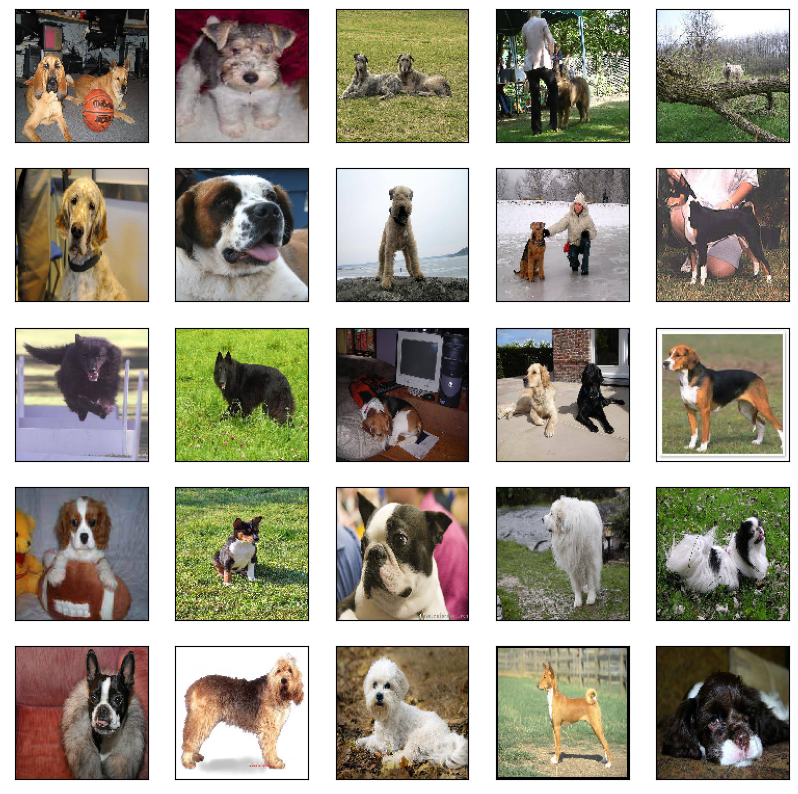

In [10]:
plt.figure(figsize=(10,10))
plt.title('Random Image from Dataset')
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_val_s[i])
    
plt.show()

In [11]:
#creating Xception model and defining the layers
def Xception_Net():
    base_model =tf.keras.applications.Xception(input_shape = (128, 128, 3), # Shape of our images
                                 include_top = False, 
                                 weights = 'imagenet', pooling='avg')
    
    base_model.trainable = True 
    base_model.layers[0].trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(93, activation='softmax'))
    
    return model


In [12]:
#calling the Xception_Net function and compiling the mdoel
model = Xception_Net()
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy']) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 93)                23901     
                                                                 
Total params: 22,065,797
Trainable params: 22,011,269
No

In [13]:
#defining the early stopping and fitting the model
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=8)

history = model.fit(X_train_s, y_train_s, epochs=100,batch_size=64,validation_data=(X_val_s,y_val_s),callbacks=[early_stop])

Epoch 1/100
100/100 [==============================] - 51s 204ms/step - loss: 4.5211 - accuracy: 0.0177 - val_loss: 4.3435 - val_accuracy: 0.0577
Epoch 2/100
100/100 [==============================] - 18s 182ms/step - loss: 4.1538 - accuracy: 0.0832 - val_loss: 3.6129 - val_accuracy: 0.1982
Epoch 3/100
100/100 [==============================] - 18s 182ms/step - loss: 3.4811 - accuracy: 0.2236 - val_loss: 2.8727 - val_accuracy: 0.3373
Epoch 4/100
100/100 [==============================] - 18s 182ms/step - loss: 2.7061 - accuracy: 0.3782 - val_loss: 2.3819 - val_accuracy: 0.4357
Epoch 5/100
100/100 [==============================] - 19s 189ms/step - loss: 1.9254 - accuracy: 0.5420 - val_loss: 1.8271 - val_accuracy: 0.5210
Epoch 6/100
100/100 [==============================] - 18s 182ms/step - loss: 1.1973 - accuracy: 0.6971 - val_loss: 1.5822 - val_accuracy: 0.5709
Epoch 7/100
100/100 [==============================] - 18s 183ms/step - loss: 0.7166 - accuracy: 0.8130 - val_loss: 1.5635 -